In [2]:
import os
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch

In [3]:
# Define paths
data_folder = '/content/EEG'    # Folder containing raw EEG .txt files (each file is one trial)
label_folder = '/content/labels'      # Folder containing label files (each file = "like" or "dislike")

# Channels, sampling info and frequency bands
channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4","P3","P4"]
frontal_channels = ["AF3", "F3", "AF4", "F4"]
sfreq = 128  # sampling frequency
bandpass = (4, 45)  # bandpass filter range
trial_length_sec = 4.0
times = np.linspace(0, trial_length_sec, int(sfreq*trial_length_sec))

# Frequency bands (adjusted to include delta)
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 20)
}


In [4]:
# load data function
def load_data(eeg_folder_path, labels_folder_path):
    eeg_signals_list = []
    labels_list = []
    for file_name in os.listdir(eeg_folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(eeg_folder_path, file_name)
            label_file_name = file_name.replace('.txt', '.lab')
            label_file_path = os.path.join(labels_folder_path, label_file_name)

            if os.path.isfile(file_path) and os.path.isfile(label_file_path):
                eeg_data = pd.read_csv(file_path, delimiter='\s+', header=None).values
                with open(label_file_path, 'r') as f:
                    label = f.read().strip().lower()
                # Handle potential typos in labels
                #if label not in ['like', 'dislike']:
                    #label = 'dislike' if 'disike' in label else label
                if label == 'like':
                    label_val = 1
                elif label == 'dislike':
                    label_val = 0
                else:
                    raise ValueError(f"Invalid label '{label}' in file: {label_file_path}")

                eeg_signals_list.append(eeg_data)
                labels_list.append(label_val)
    return np.array(eeg_signals_list), np.array(labels_list)

In [5]:

def apply_bandpass(data, sfreq, bandpass):
    """Apply a zero-phase bandpass filter to a single trial."""
    nyq = 0.5 * sfreq
    low = bandpass[0] / nyq
    high = bandpass[1] / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

In [6]:
def run_ica(raw_mne):
    """Run ICA to remove artifacts, if needed."""
    ica = ICA(n_components=14, random_state=42)
    ica.fit(raw_mne)
    # Identify and exclude artifact components based on criteria.
    ica.exclude = [0]
    raw_mne = ica.apply(raw_mne)
    return raw_mne

In [7]:
def compute_psd(data_trials, sfreq, bands, ch_names):
    """
    Compute PSD for each trial and extract band power for all defined bands.
    data_trials: ndarray of shape (n_trials, n_samples, n_channels)
    Returns: dict of band powers, each shape (n_trials, n_channels)
    """
    n_trials, n_samples, n_channels = data_trials.shape
    # Initialize dictionaries to hold band power results
    band_powers = {band: np.zeros((n_trials, n_channels)) for band in bands}

    for i in range(n_trials):
        # data for this trial: shape (n_samples, n_channels)
        # psd_array_welch expects (n_channels, n_times)
        trial_data = data_trials[i, :, :].T  # (n_channels, n_samples)

        # Compute PSD for all channels at once
        psds, freqs = psd_array_welch(
            trial_data, sfreq=sfreq, fmin=0.5, fmax=45, verbose=False
        )  # psds shape: (n_channels, n_freqs)

        # Extract band power by averaging over freq bands
        for band, (fmin, fmax) in bands.items():
            idx = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_powers[band][i, :] = psds[:, idx].mean(axis=1)

    return band_powers


In [8]:
def frontal_alpha_asymmetry(alpha_power, ch_names=frontal_channels, ch_left='F3', ch_right='F4'):
    left_idx = ch_names.index(ch_left)
    right_idx = ch_names.index(ch_right)
    return (alpha_power[:, left_idx]-alpha_power[:, right_idx]) / (alpha_power[:, right_idx] + alpha_power[:, left_idx])


In [9]:
def effort_index(theta_power, ch_names=frontal_channels, ch_left='F3', ch_right='F4'):
    left_idx = ch_names.index(ch_left)
    right_idx = ch_names.index(ch_right)
    return (theta_power[:, right_idx] - theta_power[:, left_idx]) / (theta_power[:, right_idx] + theta_power[:, left_idx])


In [10]:
# Load data
data_list, labels = load_data(data_folder, label_folder)

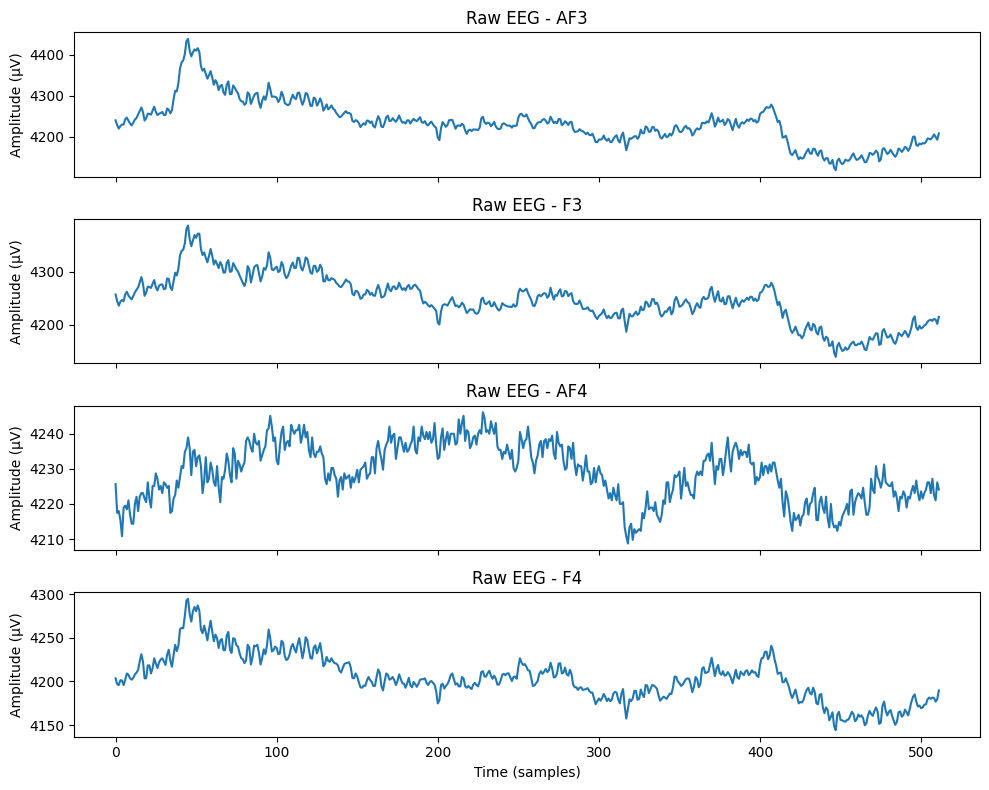

In [11]:
# Plot Raw EEG Data for AF3, F3, AF4, F4
def plot_raw_eeg(data_list, electrodes, sample_idx=None):
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(data_list))

    sample_signal_raw = data_list[sample_idx]
    fig, axs = plt.subplots(len(electrodes), 1, figsize=(10, 8), sharex=True)

    for i, ax in enumerate(axs):
        if electrodes[i] in channels:
            ch_idx = channels.index(electrodes[i])
            ax.plot(sample_signal_raw[:, ch_idx])
            ax.set_title(f'Raw EEG - {electrodes[i]}')
            ax.set_ylabel('Amplitude (µV)')

    plt.xlabel('Time (samples)')
    plt.tight_layout()
    plt.show()

# Call function to plot raw EEG data
electrodes_to_plot = ['AF3', 'F3', 'AF4', 'F4']
plot_raw_eeg(data_list, electrodes_to_plot)

In [12]:
# Preprocessing
processed_data = []
for trial_data in data_list:
    info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types='eeg')
    raw_mne = mne.io.RawArray(trial_data.T, info, verbose=False)
    raw_mne.set_eeg_reference('average', projection=False)
    raw_mne.filter(bandpass[0], bandpass[1], fir_design='firwin', verbose=False)
    raw_mne.pick_channels(frontal_channels)
    proc_data = raw_mne.get_data().T  # shape: (n_samples, n_selected_channels)
    processed_data.append(proc_data)

processed_data = np.array(processed_data)  # (n_trials, n_samples, n_channels)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing


In [13]:
# Compute ERP
like_trials = processed_data[labels == 1]
dislike_trials = processed_data[labels == 0]
erp_like = np.mean(like_trials, axis=0)   # (n_samples, n_channels)
erp_dislike = np.mean(dislike_trials, axis=0)



In [14]:
# 2. Compute PSD separately for like and dislike groups
band_powers_like = compute_psd(like_trials, sfreq, bands, ch_names=frontal_channels)
band_powers_dislike = compute_psd(dislike_trials, sfreq, bands, ch_names=frontal_channels)

alpha_power_like = band_powers_like['alpha']  # (n_like_trials, n_channels)
alpha_power_dislike = band_powers_dislike['alpha']  # (n_dislike_trials, n_channels)

theta_power_like = band_powers_like['theta']
theta_power_dislike = band_powers_dislike['theta']

In [15]:
# 3. Compute preference indices separately for ‘like’ and ‘dislike’ groups
FAA_like = frontal_alpha_asymmetry(alpha_power_like)
FAA_dislike = frontal_alpha_asymmetry(alpha_power_dislike)

Eff_like = effort_index(theta_power_like)
Eff_dislike = effort_index(theta_power_dislike)

In [ ]:
# Prepare features for ML (using combined data)
# We'll combine like and dislike data again for classification
band_powers_all = compute_psd(processed_data, sfreq, bands, ch_names=frontal_channels)
alpha_power_all = band_powers_all['alpha']
beta_power_all = band_powers_all['beta']
theta_power_all = band_powers_all['theta']
delta_power_all = band_powers_all['delta']
FAA_all = frontal_alpha_asymmetry(alpha_power_all)
Eff_all = effort_index(theta_power_all)
X = np.column_stack([FAA_all, Eff_all])
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
print(X_test)
print(y_test)

[[ 0.46146947 -0.17347151]
 [ 0.26601684  0.03237766]
 [ 0.1514096  -0.33352421]
 [-0.15355345 -0.48756844]
 [ 0.38572074 -0.38113908]
 [ 0.39300208  0.00469949]
 [-0.34494422 -0.223611  ]
 [ 0.31260743 -0.11858066]
 [ 0.4863014  -0.50878421]
 [-0.39354728  0.15670039]
 [ 0.56289724 -0.75861091]
 [ 0.11333583 -0.02472999]]
[1 0 0 0 1 1 1 1 1 1 1 0]


In [ ]:
# SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_acc = svm.score(X_test, y_test)

In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_acc = rf.score(X_test, y_test)

In [ ]:
# LSTM
# We'll use the raw EEG time-series for LSTM. Shape: (n_trials, n_samples, n_channels)
X_lstm = processed_data  # shape: (samples, time, channels)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)
print(X_test_lstm)
print(y_test_lstm)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=8, verbose=0)
lstm_loss, lstm_acc = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)

[[[ 6.66133815e-16  1.99840144e-15 -3.77475828e-15  3.77475828e-15]
  [ 5.51181408e+00 -3.14308327e+00  2.87365427e+00 -5.31649719e+00]
  [ 7.28876334e+00  2.10901360e-01 -2.13571896e+00 -5.17025131e-01]
  ...
  [ 6.36588199e-01  1.50331489e+00 -9.67181539e+00  4.17495338e+00]
  [ 1.07049386e+00 -3.66202963e-01 -2.71435807e+00 -2.17587309e+00]
  [ 3.44169138e-15  1.77635684e-15 -3.53050922e-14 -5.13478149e-15]]

 [[ 2.22044605e-16  5.55111512e-16 -4.44089210e-16  6.21724894e-15]
  [ 9.92596050e-01 -2.24785725e-01  1.95643561e+00 -5.26174012e+00]
  [ 6.84134483e-01  3.91178925e-01 -2.86967290e-01 -1.13581798e+01]
  ...
  [-8.89912382e+00 -2.23420948e+00  1.34743387e+00 -8.83346399e+00]
  [-1.80195297e+00 -9.01579793e-01 -1.81076098e+00 -4.41156188e+00]
  [ 9.43689571e-16  4.77395901e-15 -4.44089210e-15 -4.44089210e-16]]

 [[ 2.38697950e-15 -4.44089210e-14 -1.33226763e-15  1.33226763e-15]
  [ 2.89998089e+00 -2.62937557e+00 -9.78274592e-01 -4.68619055e+00]
  [-5.22137943e+00 -4.68230268e+

In [ ]:
print("SVM Accuracy:", svm_acc)
print("RF Accuracy:", rf_acc)
print("LSTM Accuracy:", lstm_acc)

SVM Accuracy: 0.5833333333333334
RF Accuracy: 0.5833333333333334
LSTM Accuracy: 0.75


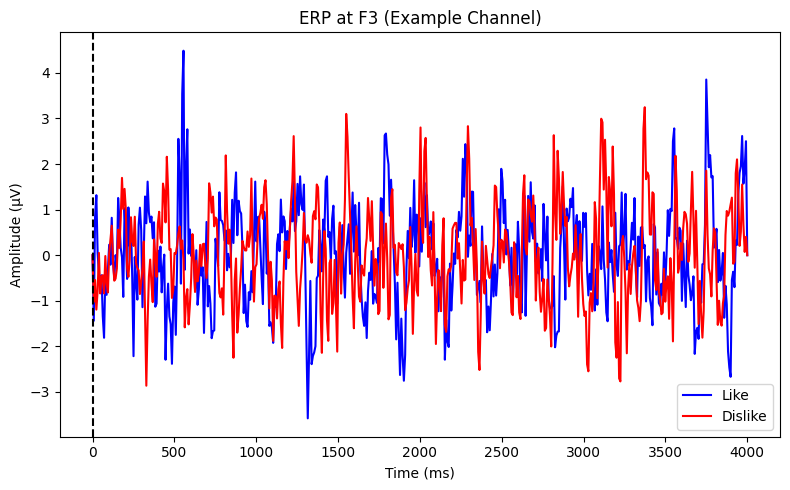

In [16]:
# 4. Plotting Figures
# Figure 1: ERP Plot
# Example using channel F3 if available
channel_index = frontal_channels.index('F3') if 'F3' in frontal_channels else 0

plt.figure(figsize=(8,5))
plt.plot(times*1000, erp_like[:, channel_index], label='Like', color='blue')
plt.plot(times*1000, erp_dislike[:, channel_index], label='Dislike', color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP at F3 (Example Channel)')
plt.legend()
plt.tight_layout()
plt.show()

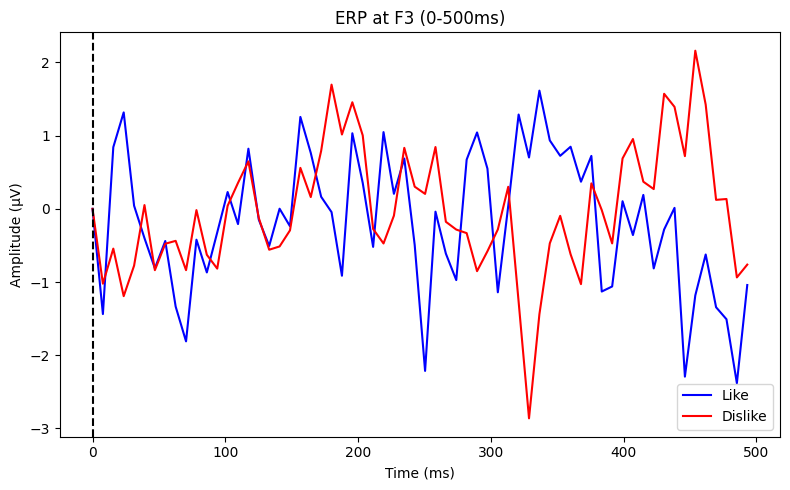

In [17]:
# For ERP Plot: Only the first 1000 ms (1 second)
time_mask = times <= 0.5  # times is in seconds, so 1.0 second = 1000 ms

plt.figure(figsize=(8,5))
plt.plot(times[time_mask]*1000, erp_like[time_mask, channel_index], label='Like', color='blue')
plt.plot(times[time_mask]*1000, erp_dislike[time_mask, channel_index], label='Dislike', color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP at F3 (0-500ms)')
plt.legend()
plt.tight_layout()
plt.show()

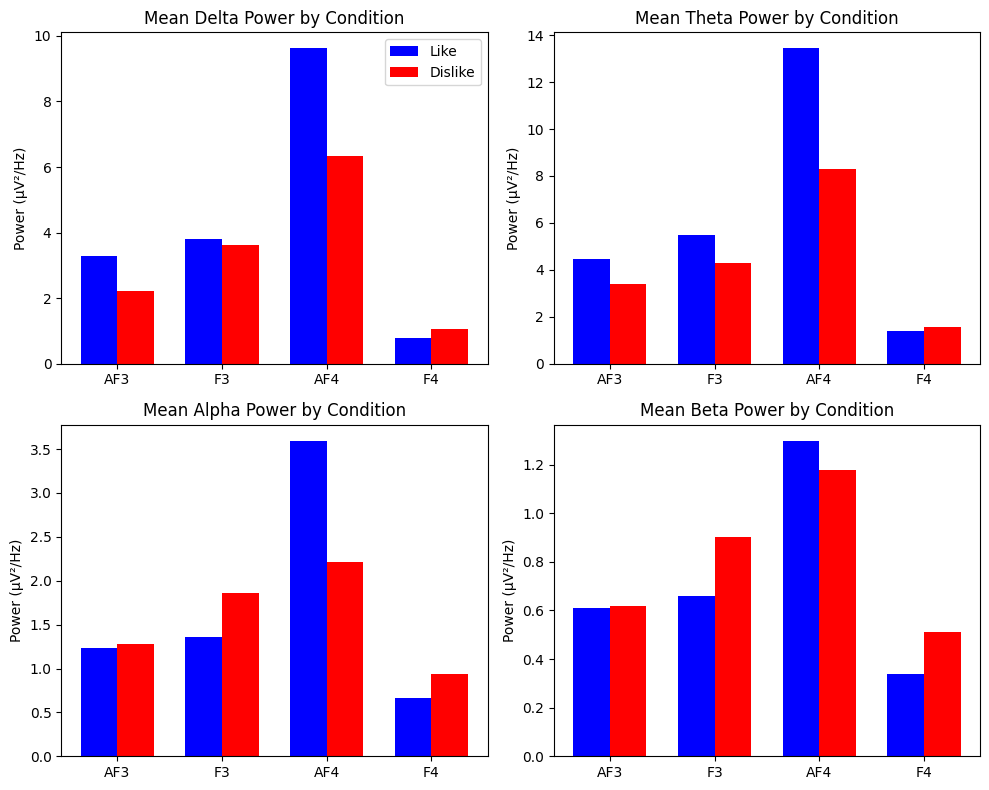

In [18]:
# Figure 2: PSD Comparisons for Like vs Dislike
# We'll create subplots for each frequency band
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, band in enumerate(['delta', 'theta', 'alpha', 'beta']):
    like_mean = band_powers_like[band].mean(axis=0)   # mean over trials, shape (n_channels,)
    dislike_mean = band_powers_dislike[band].mean(axis=0)
    x = np.arange(len(frontal_channels))
    width = 0.35
    axes[i].bar(x - width/2, like_mean, width, label='Like', color='blue')
    axes[i].bar(x + width/2, dislike_mean, width, label='Dislike', color='red')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(frontal_channels)
    axes[i].set_ylabel('Power (µV²/Hz)')
    axes[i].set_title(f'Mean {band.capitalize()} Power by Condition')
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()


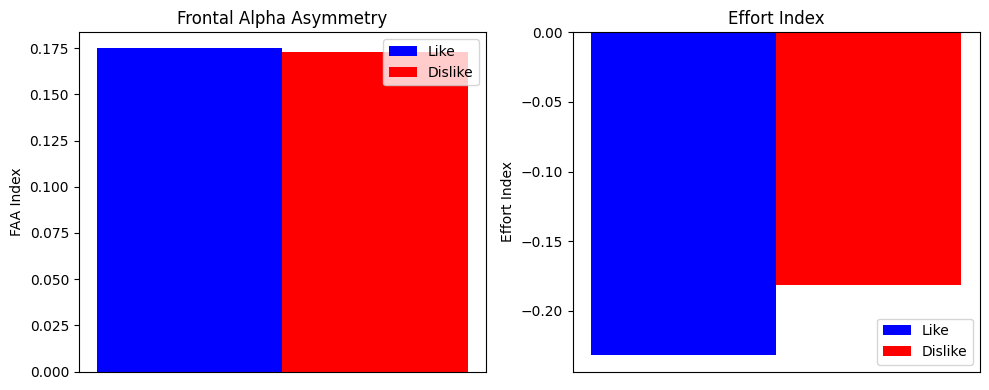

In [19]:
# Figure 3: Preference Indices Comparison
# We'll show FAA and Eff side by side for Like vs Dislike
FAA_like_mean = FAA_like.mean()
FAA_dislike_mean = FAA_dislike.mean()
Eff_like_mean = Eff_like.mean()
Eff_dislike_mean = Eff_dislike.mean()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
x = np.arange(1)  # single bar location
width = 0.35

# FAA
ax[0].bar(x - width/2, FAA_like_mean, width, label='Like', color='blue')
ax[0].bar(x + width/2, FAA_dislike_mean, width, label='Dislike', color='red')
ax[0].set_xticks([])
ax[0].set_ylabel('FAA Index')
ax[0].set_title('Frontal Alpha Asymmetry')
ax[0].legend()

# Effort
ax[1].bar(x - width/2, Eff_like_mean, width, label='Like', color='blue')
ax[1].bar(x + width/2, Eff_dislike_mean, width, label='Dislike', color='red')
ax[1].set_xticks([])
ax[1].set_ylabel('Effort Index')
ax[1].set_title('Effort Index')
ax[1].legend()

plt.tight_layout()
plt.show()